In [1]:
import gym
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# The environment
env = gym.make('CliffWalking-v0')

In [3]:
# Some utility definitions
UP, RIGHT, DOWN, LEFT = 0, 1, 2, 3
P = ['U', 'R', 'D', 'L']
INF = 99999999

## Plotting Utils

In [4]:
# Plot the minimum, maximum and average returns over a certain number of episodes
def plot_min_max_avg(mins, maxs, avgs, N=10):
    x = [i+1 for i in range(len(avgs))]
    plt.plot(x, avgs)
    plt.plot(x, mins)
    plt.plot(x, maxs)
    plt.xlabel("Number of Episodes")
    plt.ylabel(f"Returns over N = {N} episodes")
    plt.legend(["Mean", "Min", "Max"])

def plot_confused_runs(runs):
    x = [i+1 for i in range(len(runs))]
    plt.plot(x, runs)
    plt.xlabel("Episode")
    plt.ylabel("Return")
    

# General DPAgent Class

In [5]:
class DPAgent():
    """
    The general DP Agent. Base class for ValueIterationAgent and PolicyIterationAgent
    """

    # Max loop iterations in case of infinite loop
    MAX_ITER = 1000

    def __init__(self, env, gamma, theta):
        
        self.env = env

        # The discount factor gamma
        self.gamma = gamma

        # The factor for determining convergence
        self.theta = theta

        # Available state and action sets
        self.states = np.array([s for s in range(self.env.nS)])
        self.actions = np.array([a for a in range(self.env.nA)])

        # The state values
        self.values = [0.0 for s in range(self.env.nS)]

        # The policy followed by the agent
        self.policy = [np.random.choice(self.actions) for s in range(self.env.nS)]

    # Reset the state values and the policy
    def reset(self):
        self.values = [0.0 for s in range(self.env.nS)]
        self.policy = [np.random.choice(self.actions) for s in range(self.env.nS)]

    # Print out state values
    def printValues(self):
        for i in range(4):
            for j in range(12):
                print("{:.4f}".format(self.values[i*12 + j]), end=" ")
            print()
        print()

    # Print out the policy
    def printPolicy(self):
        for i in range(4):
            for j in range(12):
                print(P[self.policy[i*12 + j]], end=" ")
            print()
        print()

    # Return the expected return on taking 'action' in 'state', i.e. Q(state, action)
    def state_action_value(self, state, action):
        q = 0
        transitions = self.env.P[state][action]
        for transition in transitions:
            prob, next_state, reward, done = transition
            q += prob * (reward + self.gamma * self.values[next_state])
        return q

    # Returns the action with the highest expected return according to the current
    # state values. If multiple actions have the highest expected return, 
    # sample randomly from them.
    def greedy_policy(self, state):
        action_values = [self.state_action_value(state, action) for action in self.actions]
        max_action_value = max(action_values)
        optimal_actions = [action for action in self.actions if action_values[action] == max_action_value]
        return np.random.choice(optimal_actions)

    # Simulate an episode using an epsilon greedy policy based on current state values
    def run(self, epsilon=0, printTrajectory=False):
        self.env.reset()
        ret = 0
        curr_state = self.env.start_state_index
        if printTrajectory:
            print(str(curr_state) + "-->", end="")
        done = False
        iterations = 0
        while not done and iterations < self.MAX_ITER:
            iterations += 1
            if np.random.random() > epsilon:
                action = self.greedy_policy(curr_state)
            else:
                action = np.random.choice(self.actions)
            next_state, reward, done, info = self.env.step(action)
            ret = self.gamma * ret  + reward
            curr_state = next_state
            if printTrajectory:
                print(str(P[action]) + "-->" + str(curr_state) + "-->", end="")
        if printTrajectory:
            print("Done")
        return ret

    

# Class for a Value Iteration Agent

In [6]:
class ValueIterationAgent(DPAgent):

    def __init__(self, env, gamma=0.9, theta=0.01):
        super().__init__(env, gamma, theta)

    # Perform one step of value iteration
    def update(self):
        delta = 0
        for state in self.states:
            # Skip terminal state
            if state == self.env.nS - 1:
                continue
            v = -INF
            for action in self.actions:
                v_ = self.state_action_value(state, action)
                v = max(v, v_)
            delta = max(delta, abs(v - self.values[state]))
            self.values[state] = v
        return delta

    # Perform value iteration until convergence.
    # If intermediateRuns == True, then perform runs at every iteration and return 
    # a list of the return values obtained at each iteration
    def train(self, intermediateRuns=False, convergence_criteria="theta", num_iters=10):
        
        self.reset()
        delta = INF
        iterations = 0

        # Set convergence criteria
        if convergence_criteria == "theta":
            converged = lambda : delta < self.theta
        elif convergence_criteria == "iterations":
            converged = lambda : iterations >= num_iters

        # Used if intermediateRuns = True
        mins = []
        avgs = []
        maxs = []
        
        while not converged() and iterations < self.MAX_ITER:
            delta = self.update()
            iterations += 1
            if intermediateRuns:
                num_runs = 25
                runs = [self.run(printTrajectory=False) for _ in range(num_runs)]
                mins.append(np.min(runs))
                avgs.append(np.mean(runs))
                maxs.append(np.max(runs))

        print(f"Training finished in {iterations} iterations")
        if intermediateRuns:
            return avgs, mins, maxs
    
        

# Class for a Policy Iteration Agent

In [7]:
class PolicyIterationAgent(DPAgent):
    def __init__(self, env, gamma=0.9, theta=0.01):
        super().__init__(env, gamma, theta)
    
    # Calculate the state values based on current policy
    def policy_evaluation(self):
        delta = INF
        iterations = 0
        while delta > self.theta and iterations < self.MAX_ITER:
            iterations += 1
            delta = 0
            for state in self.states:
                if state == self.env.nS - 1:
                    continue
                v_ = self.values[state]
                self.values[state] = self.state_action_value(state, self.policy[state])
                delta = max(delta, abs(self.values[state] - v_))
    
    # Calculate the greedy policy based on state values and set that to the new policy.
    def policy_improvement(self):
        for state in self.states:
            if state == self.env.nS - 1:
                continue
            self.policy[state] = self.greedy_policy(state)
            
    # Perform one step of policy iteration.
    # Returns true if either the state values or policy is stable
    def update(self):
        old_values = [self.values[state] for state in self.states]
        old_policy = [self.policy[state] for state in self.states]
        
        self.policy_evaluation()
        self.policy_improvement()

        values_stable = (old_values == self.values)
        policy_stable = (old_policy == self.policy)

        return (values_stable or policy_stable)

    # Perform policy iteration till convegence.
    # If intermediateRuns == True, then perform runs at every iteration and return 
    # a list of the return values obtained at each iteration
    def train(self, intermediateRuns=False, convergence_criteria="stable", num_iters=10):
        self.reset()
        stable = False
        iterations = 0

        # Set convergence criteria
        if convergence_criteria == "stable":
            converged = lambda : stable
        elif convergence_criteria == "iterations":
            converged = lambda : iterations >= num_iters

        # Used if intermediateRuns = True
        mins = []
        avgs = []
        maxs = []
        
        while not converged() and iterations < self.MAX_ITER:
            stable = self.update()
            iterations += 1
            if intermediateRuns:
                num_runs = 25
                runs = [self.run(printTrajectory=False) for _ in range(num_runs)]
                mins.append(np.min(runs))
                avgs.append(np.mean(runs))
                maxs.append(np.max(runs))

        print(f"Training finished in {iterations} iterations")
        if intermediateRuns:
            return avgs, mins, maxs
        


# Confused Agent Class

In [8]:
class ConfusedAgent():
    def __init__(self, env, gamma=0.9):
        self.env = env
        self.gamma = gamma
        self.MAX_ITER = 1000
        self.states = np.array([s for s in range(self.env.nS)])
        self.actions = np.array([a for a in range(self.env.nA)])

    def run(self):
        self.env.reset()
        ret = 0
        curr_state = self.env.start_state_index
        done = False
        iterations = 0
        while not done and iterations < self.MAX_ITER:
            iterations += 1
            action = np.random.choice(self.actions)
            next_state, reward, done, info = self.env.step(action)
            ret = self.gamma * ret  + reward
            curr_state = next_state
        return ret

# Comparison of Agents

In [9]:
# Creating agents
value_iteration_agent = ValueIterationAgent(env)
policy_iteration_agent = PolicyIterationAgent(env)
confused_agent = ConfusedAgent(env)

## Performance of Value Iteration Agent

Training finished in 15 iterations


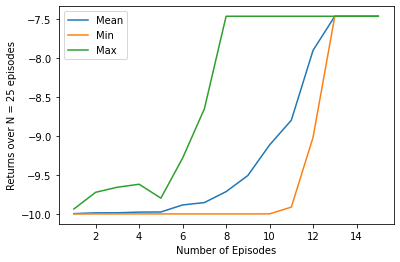

In [10]:
# Train agent
avgs, mins, maxs = value_iteration_agent.train(intermediateRuns=True)

# Plot results
plot_min_max_avg(mins, maxs, avgs, N=25)

## Performance of Policy Iteration Agent

Training finished in 14 iterations


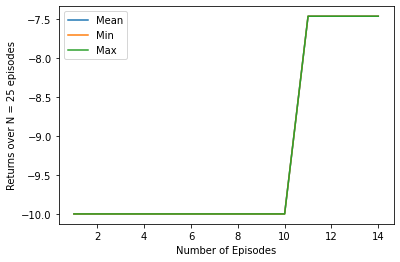

In [11]:
# Train agent
avgs, mins, maxs = policy_iteration_agent.train(intermediateRuns=True)

# Plot results
plot_min_max_avg(mins, maxs, avgs, N=25)

## Performance of Confused Agent

Average: -72.62568051689084
Minimum: -319.7137435990593
Max: -10.003204180723836


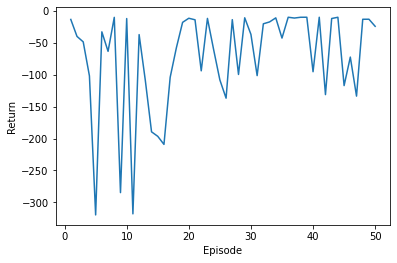

In [12]:
number_of_runs = 50
runs = [confused_agent.run() for i in range(number_of_runs)]
plot_confused_runs(runs)
print("Average:", np.mean(runs))
print("Minimum:", np.min(runs))
print("Max:", np.max(runs))

## Comparison

Clearly, the Policy and Value Iteration agents perform better than the Confused agent

# Different values of gamma

In [13]:
# Defining and training the agents
gammas = [0, 0.1, 0.5, 0.75, 1]
agents = [PolicyIterationAgent(env, gamma=gamma) for gamma in gammas]
for agent in agents:
    agent.train()

Training finished in 3 iterations
Training finished in 16 iterations
Training finished in 11 iterations
Training finished in 11 iterations
Training finished in 12 iterations


In [14]:
# Comparing Policies
for i in range(5):
    print(f"Policy for agent with gamma = {gammas[i]}:")
    agents[i].printPolicy()

Policy for agent with gamma = 0:
R U L L D L L L D R L U 
U R L D R D R D D L L R 
L L L L U U U R U R U R 
L L U U U U U U U U U R 

Policy for agent with gamma = 0.1:
R R D D R D R R D D D D 
R D D R R D R R R R R D 
R R R R R R R R R R R D 
U U U U U U U U U U R R 

Policy for agent with gamma = 0.5:
D R R R R R D D D R D D 
R D R D R R D D R R D D 
R R R R R R R R R R R D 
U U U U U U U U U U R R 

Policy for agent with gamma = 0.75:
R R D D D R R D D D D D 
D R R R R R D D D R D D 
R R R R R R R R R R R D 
U U U U U U U U U U R D 

Policy for agent with gamma = 1:
R R D D R R D R R D D D 
D D R R D D D D R D D D 
R R R R R R R R R R R D 
U U U U U U U U U U R R 

